In [28]:
import numpy as np
import pandas as pd
import torch

import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset

from Dataset.economy import EconomyDataset
from Model.LSTM import LSTM

import matplotlib.pyplot as plt

In [29]:
# 데이터 다운 & 전처리

df = pd.read_excel('../데이터/economy/economy_all.xlsx')
df = df['국고채금리'].values

In [30]:
len_df = len(df)
train_len = int(len_df *0.6)
val_len = int(len_df * 0.3)

batch_size = 2

train_dataset = EconomyDataset(df[:train_len])
train_loader = DataLoader(train_dataset, batch_size=batch_size)

val_dataset = EconomyDataset(df[train_len:train_len+val_len])
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = EconomyDataset(df[train_len+val_len:])
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [31]:
for x,y in train_loader:
  print("X 크기 : {}".format(x.shape))
  print("Y 크기 : {}".format(y.shape))
  break

X 크기 : torch.Size([2, 5])
Y 크기 : torch.Size([2])


In [32]:
input_size = 5
hidden_size = 20
Model = LSTM(input_size, hidden_size)

In [33]:
# 데이터 & 모델에 device 붙임!!!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

model = Model.to(device)

print('작동하는지 실험')
basic_data = torch.rand((1,input_size))
model(basic_data)


cpu is available
작동하는지 실험


tensor([-0.0645], grad_fn=<SelectBackward0>)

In [34]:
criterion = nn.MSELoss()

lr = 1e-3
num_epochs = 10000
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

epoch : 0
train
1.5198866575956345
Calculating validation results...
val
loss: 5.9149169 || 
epoch : 1
train
0.5246370649286385
Calculating validation results...
val
loss: 2.7767486 || 
epoch : 2
train
0.08517689707514364
Calculating validation results...
val
loss: 1.5199598 || 
epoch : 3
train
0.060835641641178564
Calculating validation results...
val
loss: 1.3095794 || 
epoch : 4
train
0.05907103933551015
Calculating validation results...
val
loss: 1.2270163 || 
epoch : 5
train
0.054820021278734705
Calculating validation results...
val
loss: 1.1448592 || 
epoch : 6
train
0.0509966247729357
Calculating validation results...
val
loss: 1.066257 || 
epoch : 7
train
0.04767288477818636
Calculating validation results...
val
loss: 0.9941598 || 
epoch : 8
train
0.04495633713342049
Calculating validation results...
val
loss: 0.9312562 || 
epoch : 9
train


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.042863302235893005
Calculating validation results...
val
loss: 0.87926908 || 
epoch : 10
train
0.04127149074840167
Calculating validation results...
val
loss: 0.83790084 || 
epoch : 11
train
0.040012461562833654
Calculating validation results...
val
loss: 0.80532938 || 
epoch : 12
train
0.0389590368692458
Calculating validation results...
val
loss: 0.77941743 || 
epoch : 13
train
0.03803298649566794
Calculating validation results...
val
loss: 0.75835116 || 
epoch : 14
train
0.037187365385511054
Calculating validation results...
val
loss: 0.74075738 || 
epoch : 15
train
0.03639319246426096
Calculating validation results...
val
loss: 0.72564099 || 
epoch : 16
train
0.035631901102847065
Calculating validation results...
val
loss: 0.71229214 || 
epoch : 17
train
0.03489117957410756
Calculating validation results...
val
loss: 0.70020667 || 
epoch : 18
train
0.0341626688986535
Calculating validation results...
val
loss: 0.68902808 || 
epoch : 19
train
0.033440547754410015
Calculating valid

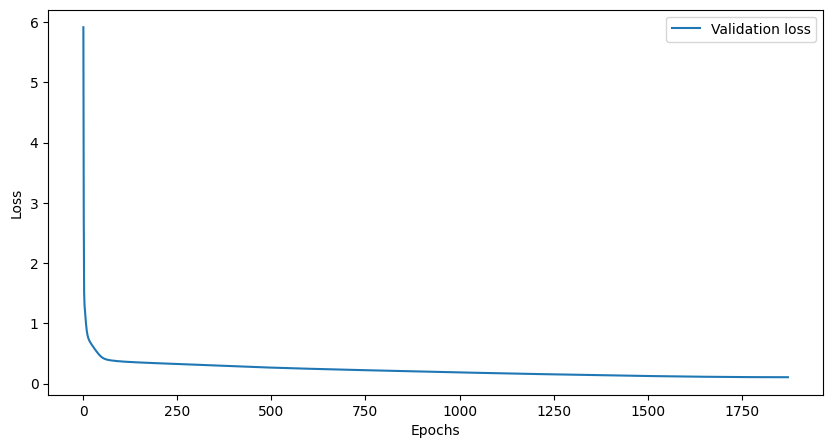

In [35]:
train_n = len(train_dataset)
val_n = len(val_dataset)

val_loss_list = []
best_val_loss = float('inf')
stop_counter = 0
stop_criteria = 3

for epoch in range(num_epochs):
    print('epoch : {}'.format(epoch))
    running_loss = 0.0
    num = 0
    print("train")
    model.train()
    for inputs, labels in train_loader:  # dataloader 함수에 def __len__에 return 값만큼 반복함
        inputs = inputs.to(device)
        labels = labels.to(device)
        out = model(inputs)
        loss = criterion(out, labels)

        optimizer.zero_grad() #
        loss.backward() # loss가 최소가 되게하는
        optimizer.step() # 어떤 방법으로 learning rate를 움직일거이냐
        running_loss += loss.item() # 한 배치의 loss 더해주고,


    print(running_loss/train_n)

    with torch.no_grad():
            print("Calculating validation results...")
            model.eval()
            val_loss = 0
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outs = model(inputs)

                loss= criterion(outs, labels)
                val_loss += loss.item()

            avg_val_loss = val_loss/val_n
            val_loss_list.append(avg_val_loss)

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                stop_counter = 0            
                torch.save(model.state_dict(), 'Checkpoint/economic_best_model.pth')
            else:
                stop_counter += 1

            print("val")
            print(
                f"loss: {avg_val_loss:4.8} || "
            )

            if stop_counter >= stop_criteria:
                print('Early stopping triggered.')
                break
    
    print('======================================================')

plt.figure(figsize=(10, 5))
plt.plot(val_loss_list, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()